# Huygens' Metasurface

In this notebook, the Huygens' Metasurface figure 5(a) and 5(c) are reproduced, and mesh study is done for the transmittance. [Link to Paper](https://duke.box.com/s/03x3nr1clvwb9c99z7ii6kb7o8fq1uyv)

In [39]:
# Import the necessary packages
import matplotlib.pyplot as plt
import numpy as np
import tidy3d as td
import tidy3d.web as web
import scienceplots

# Set logging level to ERROR to reduce output verbosity
td.config.logging_level = "ERROR"

class Sim:
    def __init__(self, wvl_min, wvl_max, N):
        self.fr = td.FreqRange.from_wvl_interval(wvl_min=wvl_min, wvl_max=wvl_max)
        self.N=N
        self.freqs= self.fr.freqs(N)
        self.freq0 = self.fr.freq0
        self.lda0 = td.C_0 / self.fr.freq0
        self.fwidth = self.fr.fmax - self.fr.fmin
        self.P = None
        self.spc = 3
        self.Lz = self.spc + self.spc
        self.min_steps_per_wvl=32
        self.grid_spec = None 
        self.sources = []
        self.monitors = []
        self.structures=[]
        self.run_time = 200 / self.fwidth
        self.bc = td.BoundarySpec(
            x=td.Boundary.periodic(), 
            y=td.Boundary.periodic(), 
            z=td.Boundary.pml()
        )
        self.sims = {}
        self.path_dir = None
        self.batch_data = None
        self.ctr = 0
    
    def add_structure(self, structure, periodicity=None):
        if periodicity: 
            self.P = periodicity
        self.structures.append(structure)

    def add_cylinder(self, radius, height, medium, periodicity=None):
        if periodicity: 
            self.P = periodicity
        self.Lz = self.spc + self.spc + 2 * height
        self.structures.append(
            td.Structure(
                geometry=td.Cylinder(
                    center=[0, 0, height / 2], 
                    radius=radius, length=height, axis=2), 
                    medium=medium,
                    name="cylinder"
            )
        )

    def add_substrate(self, medium, periodicity=None):
        if periodicity: 
            self.P = periodicity
        self.structures.append(
            td.Structure(
                geometry=td.Box(
                    center=(0,0,-self.Lz/2),
                    size=(td.inf,td.inf,self.Lz)
                ),
                medium=medium,
                name=f'background{self.ctr}'
            )
        )
        self.ctr += 1

    def add_superstrate(self, medium, periodicity=None):
        if periodicity: 
            self.P = periodicity
        self.structures.append(
            td.Structure(
                geometry=td.Box(
                    center=(0,0,self.Lz/2),
                    size=(td.inf,td.inf,self.Lz)
                ),
                medium=medium,
                name=f'background{self.ctr}'
            )
        )
        self.ctr += 1

    def add_background(self, medium, periodicity=None):
        if periodicity: 
            self.P = periodicity
        self.structures.append(
            td.Structure(
                geometry=td.Box(
                    center=(0,0,0),
                    size=(td.inf,td.inf,td.inf)
                ),
                medium=medium,
                name=f'background{self.ctr}'
            )
        )
        self.ctr += 1

    def run(self, path_dir, normalize=False):
        self.path_dir = path_dir
        self.define_sim(normalize=normalize)
        batch = web.Batch(
            simulations=self.sims, 
            verbose=True)
        self.batch_data = batch.run(path_dir=self.path_dir)

    def inspect(self, save_as=None):
        if len(self.structures) == 0:
            print("No structures defined yet!")
            return
        self.define_sim()
        # Always visualize simulation before running
        fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(12, 6))
        ax1.tick_params(axis='x', labelsize=7)
        ax2.tick_params(axis='x', labelsize=7)
        sim_actual = next(iter(self.sims.values()))
        sim_actual.plot(x=0, ax=ax1)
        sim_actual.plot_grid(x=0, ax=ax1)
        sim_actual.plot(y=0, ax=ax2)
        sim_actual.plot_grid(y=0, ax=ax2)
        sim_actual.plot(z=0.01, ax=ax3)
        sim_actual.plot_grid(z=0.01, ax=ax3)
        if save_as:
            plt.savefig(save_as, dpi=300)
        plt.show()

    def plot_3d(self):
        if len(self.structures) == 0:
            print("No structures defined yet!")
            return
        self.define_sim()
        sim_actual = next(iter(self.sims.values()))
        return sim_actual.plot_3d()

    def define_sim(self, normalize=False):
        if self.P is not None and self.grid_spec is None: 
            dl = self.P / self.min_steps_per_wvl
            horizontal_grid = td.UniformGrid(dl=dl)
            vertical_grid = td.AutoGrid(min_steps_per_wvl=self.min_steps_per_wvl)
            self.grid_spec = td.GridSpec(
                grid_x=horizontal_grid,
                grid_y=horizontal_grid,
                grid_z=vertical_grid,
            )
        if normalize:
            empty_structures = [s for s in self.structures if ('background' in s.name)]
            self.sims["sim_norm"] = td.Simulation(
                size=[self.P, self.P, self.Lz],
                grid_spec=self.grid_spec,
                structures=empty_structures,  # Only background
                sources=self.sources,
                monitors=self.monitors,
                run_time=self.run_time,
                boundary_spec=self.bc
            )
        if len(self.sims) == 0:
            if len(self.sources) == 0:
                self.sources = [td.PlaneWave(
                    source_time=self.fr.to_gaussian_pulse(),
                    size=(td.inf, td.inf, 0),
                    center=(0, 0, self.Lz/2 - self.spc + 0.5 * self.lda0),
                    direction="-",
                    pol_angle=0
                )]
            if len(self.monitors) == 0:
                self.monitors = [td.DiffractionMonitor(
                    center=(0, 0, -self.Lz/2 + self.spc - 0.5 * self.lda0),
                    size=(td.inf, td.inf, 0),
                    freqs=self.freqs,
                    name='diffraction_monitor',
                    normal_dir="+"
                )]
            self.sims["sim"] = td.Simulation(
                size=[self.P, self.P, self.Lz],
                grid_spec=self.grid_spec,
                structures=self.structures,
                sources=self.sources,
                monitors=self.monitors,
                run_time=self.run_time,
                boundary_spec=self.bc
            )
            
    

In [37]:
sim = Sim(wvl_min=1.1, wvl_max=1.6, N=301)
sim.inspect()

No structures defined yet!


In [40]:
h = 0.220  # height of the cylinder
r = 0.242  # radius of the cylinder
P = 0.666
n_Si = 3.5
Si = td.Medium(permittivity=n_Si**2, name='Si')

# Background medium for the first simulation
n_glass = 1.4
n_SiO2 = 1.45
glass = td.Medium(permittivity=n_glass**2, name='glass')
SiO2 = td.Medium(permittivity=n_SiO2**2, name='oxide')

sim = Sim(wvl_min=1.1, wvl_max=1.6, N=301)
sim.add_cylinder(radius=r, height=h, medium=Si, periodicity=P)
sim.add_substrate(medium=SiO2)
sim.add_superstrate(medium=glass)
sim.plot_3d()

For the transmittance and phase, two different background materials were used based in the paper, so two separate simulations were ran (with background medium as the only difference).

Note: Several other technical variables need to be changed. In tidy3D simulation, transmittance should be measured with `td.FluxMonitor` and phase should be measured with `td.FieldMonitor`. The `run_time` also needs to increase since the background medium has a higher refractive index in the second simulation than the first, so waves will travel more slowly.

---

**Simulation 1**

![Top Layer n=1.4, Bottom Layer n=1.45](../assets/huygens_structure_substrate.png)

---

**Simulation 2**

![Background medium n=1.66](../assets/huygens_structure_polymer.png)

---

**Simulation Results**

![](../assets/huygens.png)

---

**Mesh Study Results**

![Convergence of Transmittance](../assets/mesh_convergence.png)

---

## Initialization

Here we follow the seven steps of initialization I wrote down in the tutorial: 

0. Frequency Range Specification
1. Computational Domain Size
2. Grid Specifications (Discretization size)
3. Structures and Materials
4. Sources
5. Monitors
6. Run time
7. Boundary Condition Specification

## 0 Frequency Range Specification

In [76]:
# 0 Define a FreqRange object with desired wavelengths
fr = td.FreqRange.from_wvl_interval(wvl_min=1.1, wvl_max=1.6)
N = 301 # num_points
freq0 = fr.freq0
lda0 = td.C_0 / fr.freq0

## 1 Computational Domain Size

In [77]:
# 1 Computational Domain Size
h = 0.220  # Height of cylinder
spc = 2
Lz = spc + h + h + spc

Px = Py = P = 0.666 # periodicity
sim_size = [Px, Py, Lz]

## 2 Grid Resolution

Grid resolution is uniform grid in the horizontal direction with a yee cell length of $\frac{P}{32}$ where $P$ is the periodicity. In the vertical direction, `AutoGrid` means it's non-uniform and adjusted based on the wavelength of the particular medium. Here, `min_steps_per_wvl=32` means we are taking a minimum of 32 steps based on the wavelength, which will be shorter in the medium with a higher index of refraction.

In [2]:
# 2 Grid Resolution
dl = P / 32
horizontal_grid = td.UniformGrid(dl=dl)
vertical_grid = td.AutoGrid(min_steps_per_wvl=32)
grid_spec=td.GridSpec(
    grid_x=horizontal_grid,
    grid_y=horizontal_grid,
    grid_z=vertical_grid,
)

NameError: name 'P' is not defined

## 3 Structures and Materials

**Structures and Materials for the meta-atom**

In [79]:
r = 0.242  # radius of the cylinder
n_Si = 3.5
Si = td.Medium(permittivity=n_Si**2, name='Si')
cylinder = td.Structure(
    geometry=td.Cylinder(center=[0, 0, h / 2], radius=r, length=h, axis=2), medium=Si
)

**Background Medium for Figure 5(a) ($n_1=1.4, n_2=1.45$)**

In [80]:
# Background medium for the first simulation
n_glass = 1.4
n_SiO2 = 1.45
glass = td.Medium(permittivity=n_glass**2, name='glass')
SiO2 = td.Medium(permittivity=n_SiO2**2, name='oxide')

substrate = td.Structure(
    geometry=td.Box(
        center=(0,0,-Lz/2),
        size=(td.inf,td.inf,2 * (spc+h))
    ),
    medium=SiO2,
    name='substrate'
)

glass = td.Structure(
    geometry=td.Box(
        center=(0,0,Lz/2),
        size=(td.inf,td.inf,2 * (spc+h))
    ),
    medium=glass,
    name='superstrate'
)

**Background Medium for Figure 5(c) ($n=1.66$)**

In [81]:
# Background medium for the second simulation
# Polymer
n_polymer = 1.66
polymer = td.Structure(
    geometry=td.Box(
        center=(0,0,0),
        size=(td.inf,td.inf,td.inf)
    ),
    medium=td.Medium(permittivity=n_polymer**2, name='polymer'),
    name='polymer'
)

## 4 The Source

The source is a simple Plane wave that traverses in the -z axis, placed $\frac{\lambda_0}{2}$ distance above the metaatom in the computational domain. Polarization is along the x-axis, that's what `pol_angle=0` means.

In [82]:
source = td.PlaneWave(
    source_time=fr.to_gaussian_pulse(),
    size=(td.inf, td.inf, 0),
    center=(0, 0, Lz/2 - spc + 0.5 * lda0),
    direction="-",
    pol_angle=0
)

## 5 Monitors

**Monitor for Transmittance**

In [83]:
flux_monitor = td.FluxMonitor(
    center=(0, 0, -Lz/2 + spc - 0.5 * lda0),
    size=(td.inf, td.inf, 0),
    freqs=fr.freqs(N),
    name="flux_monitor"
)

**Monitor for Phase**

In [84]:
# We use FieldMonitor instead of DiffractionMonitor because
# DiffractionMonitor only gives you amplitudes of diffraction orders, 
# losing phase detail if you care about continuous phase.
field_monitor = td.FieldMonitor(
    center=(0, 0, -Lz/2 + spc - 0.5 * lda0),
    size=(td.inf, td.inf, 0),
    fields=["Ex"],
    freqs=fr.freqs(N),
    name="field_monitor"
)

## 6 Run Time

In [85]:
bandwidth = fr.fmax - fr.fmin
run_time_short = 50 / bandwidth # run_time for the transmittance simulation
run_time_long = 200 / bandwidth # run_time for the phase simulation

## 7 Boundary Conditions

We apply PML in the +Z and -Z surfaces.

In [86]:
bc = td.BoundarySpec(
    x=td.Boundary.periodic(), 
    y=td.Boundary.periodic(), 
    z=td.Boundary.pml()
)

## Helper Function for simulation

Since we have to run simulation two times, it is convenient to abstract out what are the differences to the two simulations and make defining simulations easier. Always follow the [DRY Principle](https://en.wikipedia.org/wiki/Don%27t_repeat_yourself).

In [87]:
def simulation_helper(background, monitors, run_time):
    """
    Create normalization and actual tidy3d simulations, visualize geometry, 
    and return both as a dictionary.

    Parameters
    ----------
    background : list of td.Structure
        Background structures (without the cylinder).
    monitors : list of td.Monitor
        Monitors for the normalization run.
    run_time : float
        Run time for the normalization simulation.

    Returns
    -------
    dict
        {"norm": Simulation without cylinder,
         "actual": Simulation with cylinder}

    Notes
    -----
    Saves cross-sectional plots of the actual simulation (x=0, y=0, z=0) 
    with grid overlay for verification.
    """
    sim_empty=td.Simulation(
        size=sim_size,
        grid_spec=grid_spec,
        structures=background,
        sources=[source],
        monitors=monitors,
        run_time=run_time,
        boundary_spec=bc
    )

    background.append(cylinder)
    sim_actual = td.Simulation(
        size=sim_size,
        grid_spec=grid_spec,
        structures=background,
        sources=[source],
        monitors=monitors,
        run_time=run_time,
        boundary_spec=bc
    )

    # Always visualize simulation before running
    fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(12, 6))
    ax1.tick_params(axis='x', labelsize=7)
    ax2.tick_params(axis='x', labelsize=7)
    sim_actual.plot(x=0, ax=ax1)
    sim_actual.plot_grid(x=0, ax=ax1)
    sim_actual.plot(y=0, ax=ax2)
    sim_actual.plot_grid(y=0, ax=ax2)
    sim_actual.plot(z=0, ax=ax3)
    sim_actual.plot_grid(z=0, ax=ax3)
    plt.savefig(f'huygens_structure_{background[0].name}.png', dpi=300)
    plt.show()

    sims = {
        "norm": sim_empty,
        "actual": sim_actual,
    }

    return sims



## Transmittance Simulation

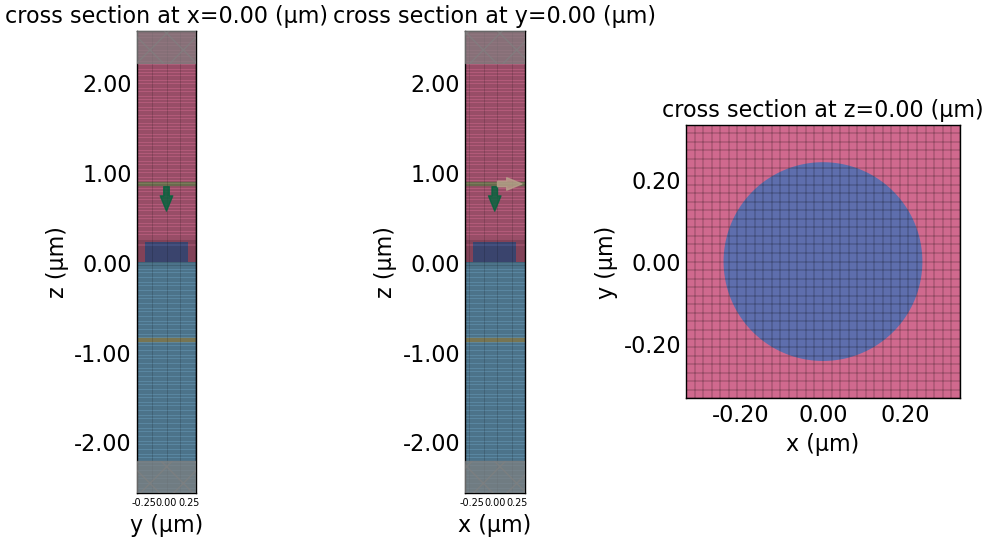

In [88]:
sims = simulation_helper(
    background=[substrate, glass],
    monitors=[flux_monitor],
    run_time=run_time_short
)

In [89]:
batch = web.Batch(simulations=sims, verbose=True)
batch_data = batch.run(path_dir="data/huygens5a")

Output()

02:20:56 EDT Started working on Batch containing 2 tasks.

02:20:57 EDT Maximum FlexCredit cost: 0.050 for the whole batch.

             Use 'Batch.real_cost()' to get the billed FlexCredit cost after the
             Batch has completed.

Output()

02:20:58 EDT Batch complete.

Output()

## Transmittance Results

In [90]:
# this uses scienceplots to make plots look better
plt.style.use(['science', 'notebook', 'grid'])
T = batch_data["actual"]["flux_monitor"].flux / batch_data["norm"]["flux_monitor"].flux

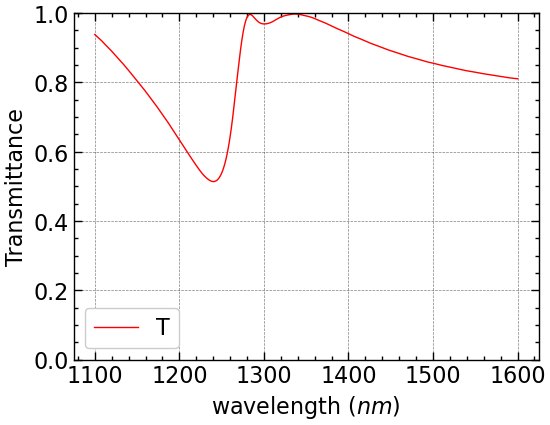

In [91]:
# plot transmission, compare to paper results, look similar
fig, ax = plt.subplots(1, 1, figsize=(6, 4.5))
plt.plot(td.C_0 / fr.freqs(N) * 1000, np.abs(T)**2, "r", lw=1, label="T")
plt.xlabel(r"wavelength ($nm$)")
plt.ylabel("Transmittance")
plt.ylim(0, 1)
plt.legend()
plt.show()

## Phase Simulation

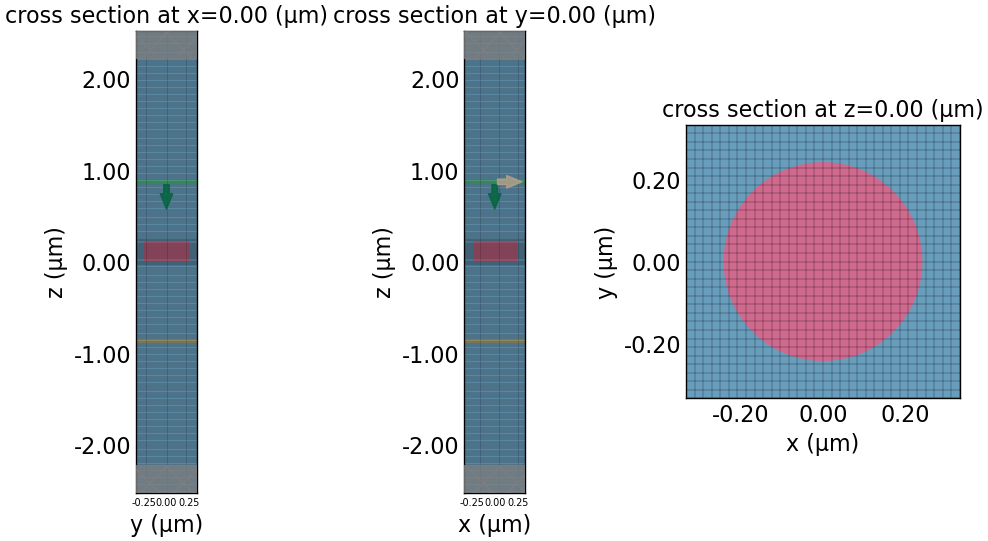

In [92]:
sims = simulation_helper(
    background=[polymer],
    monitors=[field_monitor],
    run_time=run_time_long
)

In [93]:
batch = web.Batch(simulations=sims, verbose=True)
batch_data = batch.run(path_dir="data/huygens5c")

Output()

02:21:11 EDT Started working on Batch containing 2 tasks.

02:21:13 EDT Maximum FlexCredit cost: 0.050 for the whole batch.

             Use 'Batch.real_cost()' to get the billed FlexCredit cost after the
             Batch has completed.

Output()

02:21:14 EDT Batch complete.

Output()

## Phase Results

In [94]:
# Data Extraction
Ex_actual = batch_data["actual"]["field_monitor"].Ex 
Ex_norm = batch_data["norm"]["field_monitor"].Ex
Ex = Ex_actual / Ex_norm

In [95]:
# 1. Compute average over the xy-plane
Ex_avg = np.mean(Ex[:, :, 0, :], axis=(0,1))

# 2. Compute phase
phase_avg = np.angle(Ex_avg)

# 3. Unwrap phase to remove ±pi jumps
phase_avg_unwrapped = np.unwrap(phase_avg)

# 4. Make relative to first point (optional)
phase_rel = phase_avg_unwrapped - phase_avg_unwrapped[0]

phase_actual = np.unwrap(np.angle(np.mean(Ex_actual[:, :, 0, :], axis=(0,1))))
phase_norm = np.unwrap(np.angle(np.mean(Ex_norm[:, :, 0, :], axis=(0,1))))

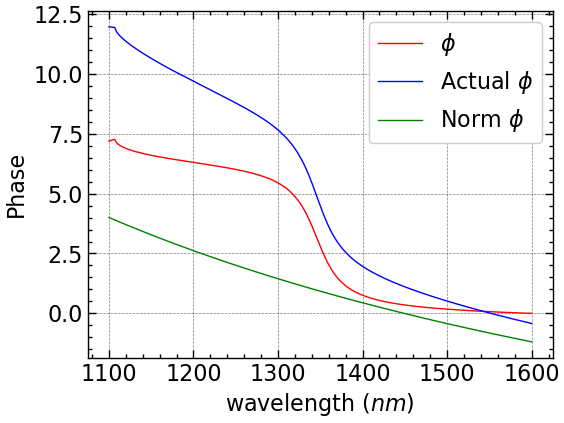

In [96]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4.5))
plt.plot(td.C_0 / fr.freqs(N) * 1000, phase_rel, "r", lw=1, label="$\phi$")
plt.plot(td.C_0 / fr.freqs(N) * 1000, phase_actual, "b", lw=1, label="Actual $\phi$")
plt.plot(td.C_0 / fr.freqs(N) * 1000, phase_norm, "g", lw=1, label="Norm $\phi$")
plt.xlabel(r"wavelength ($nm$)")
plt.ylabel("Phase")
plt.legend()
plt.show()

## Final Plotting

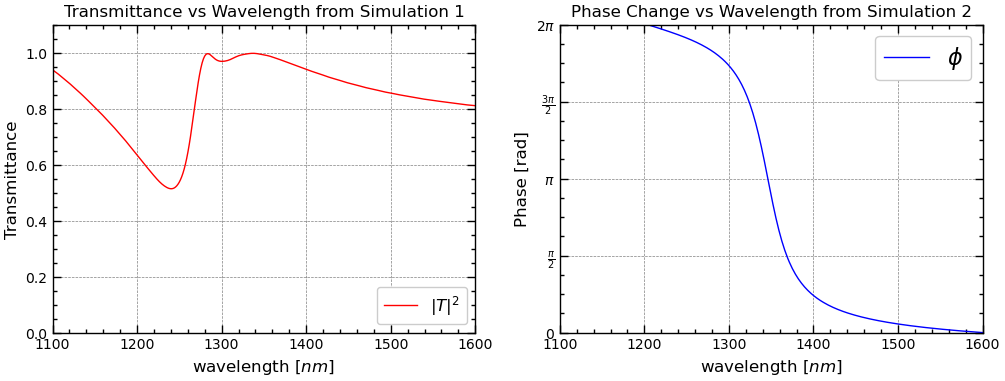

In [97]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# work on the first figure
ax = axes[0]
ax.tick_params(axis="both", labelsize=10)
ax.plot(td.C_0 / fr.freqs(N) * 1000, np.abs(T)**2, "r", lw=1, label="$|T|^2$")
ax.set_xlabel(r"wavelength [$nm$]", fontsize=12)
ax.set_ylabel("Transmittance", fontsize=12)
ax.set_title("Transmittance vs Wavelength from Simulation 1", fontsize=12)
ax.set_xlim(1100, 1600)
ax.set_ylim(0, 1.1)
ax.legend(loc="lower right", fontsize=12)

# work on the second figure
ax = axes[1]
ax.tick_params(axis="both", labelsize=10)
ax.plot(td.C_0 / fr.freqs(N) * 1000, phase_rel, "b", lw=1, label="$\phi$")
ax.set_xlabel(r"wavelength [$nm$]", fontsize=12)
ax.set_ylabel("Phase [rad]", fontsize=12)
ax.set_title("Phase Change vs Wavelength from Simulation 2", fontsize=12)
ax.set_xlim(1100, 1600)
ax.set_ylim(0, np.pi*2)
yticks = [0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi]
ytick_labels = [r"$0$", r"$\frac{\pi}{2}$", r"$\pi$", 
                r"$\frac{3\pi}{2}$", r"$2\pi$"]
ax.set_yticks(yticks)
ax.set_yticklabels(ytick_labels)
ax.legend()

plt.savefig("huygens.png", dpi=300)

## Mesh Study

Here, we set out to study the effect of different yee cell length on the transmittance. 

In [98]:
dls = [P/2, P/4, P/8, P/16, P/32, P/64, P/128] # mesh study list
sims = {}

In [99]:
# for each dl in dls
for i, dl in enumerate(dls):
    # 2 Grid Specifications
    horizontal_grid = td.UniformGrid(dl=dl)
    vertical_grid = td.AutoGrid(min_steps_per_wvl=32)
    grid_spec=td.GridSpec(
        grid_x=horizontal_grid,
        grid_y=horizontal_grid,
        grid_z=vertical_grid,
    )

    # 4 Sources
    source = td.PlaneWave(
        source_time=fr.to_gaussian_pulse(),
        size=(td.inf, td.inf, 0),
        center=(0, 0, Lz/2 - spc + 2 * dl),
        direction="-",
        pol_angle=0
    )

    # 5 Monitor
    monitor = td.FluxMonitor(
        center=(0, 0, -Lz/2 + spc - 2*dl),
        size=(td.inf, td.inf, 0),
        freqs=fr.freqs(N),
        name="flux"
    )

    sim_empty=td.Simulation(
        size=sim_size,
        grid_spec=grid_spec,
        structures=[substrate, glass],
        sources=[source],
        monitors=[monitor],
        run_time=run_time_short,
        boundary_spec=bc
    )

    sim_actual = td.Simulation(
        size=sim_size,
        grid_spec=grid_spec,
        structures=[substrate, glass, cylinder],
        sources=[source],
        monitors=[monitor],
        run_time=run_time_short,
        boundary_spec=bc
    )

    sims[f"norm{i}"] = sim_empty
    sims[f"actual{i}"] = sim_actual  

In [100]:
# verify the sims dictionary
print(sims.keys())
batch = web.Batch(simulations=sims, verbose=True)

dict_keys(['norm0', 'actual0', 'norm1', 'actual1', 'norm2', 'actual2', 'norm3', 'actual3', 'norm4', 'actual4', 'norm5', 'actual5', 'norm6', 'actual6'])


In [101]:
# run the simulations
batch_data = batch.run(path_dir="data")

Output()

02:21:47 EDT Started working on Batch containing 14 tasks.

02:21:59 EDT Maximum FlexCredit cost: 0.392 for the whole batch.

             Use 'Batch.real_cost()' to get the billed FlexCredit cost after the
             Batch has completed.

Output()

02:22:21 EDT Batch complete.

Output()

## Mesh Study Results

In [104]:
# Extract results
x = td.C_0 / fr.freqs(N) * 1000
Ts = []
for i in range(len(dls)):
    Ts.append(batch_data[f"actual{i}"]["flux"].flux / batch_data[f"norm{i}"]["flux"].flux)

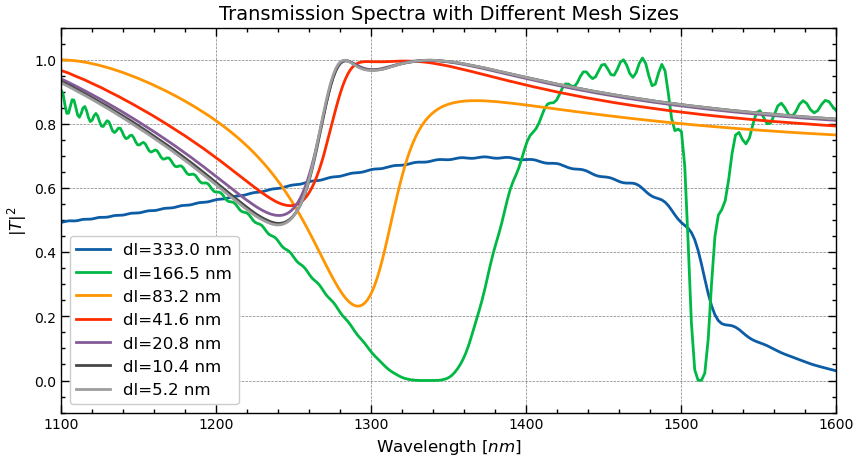

In [107]:
# Plot results
plt.figure(figsize=(10, 5))
for i, T in enumerate(Ts):
    plt.plot(x, np.abs(T)**2, "-",lw=2, label=f"dl={dls[i] * 1000:.1f} nm")
plt.xlabel(r"Wavelength [$nm$]", fontsize=12)
plt.ylabel(r"$|T|^2$", fontsize=12)
plt.xlim(1100, 1600)
plt.ylim(-0.1, 1.1)
plt.legend(fontsize=12)
plt.tick_params(axis='both', labelsize=10) # change tick label size to 10
plt.title("Transmission Spectra with Different Mesh Sizes", fontsize=14)
plt.savefig("mesh_convergence.png", dpi=300)
plt.show()

In [1]:
import tidy3d
print(tidy3d.__version__)

2.9.1
